https://github.com/python-engineer/pytorchTutorial/blob/master/15_transfer_learning.py


april 29

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [3]:
#sizes,transform to tensor, normalizes

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

dzall_t_t   split into train / val     15% in test   

In [4]:
data_dir = '/Users/Hutch/Desktop/dz_t_t_all'

In [5]:

#input images and transform
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# load
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#pull out labels

class_names = image_datasets['train'].classes

In [6]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 381
    Root location: /Users/Hutch/Desktop/dz_t_t_all/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )

In [7]:
type(image_datasets['train'])

torchvision.datasets.folder.ImageFolder

In [8]:
#check if cuda available in order to use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['depuy', 'zimmer']


In [9]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

In [11]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

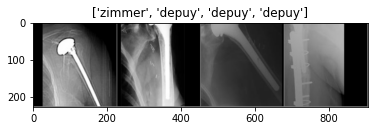

In [12]:
imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
        
# load best model weights
    model.load_state_dict(best_model_wts)
    return model

connect to resnet18
using optimized weights form resnet18 trained on the imagenet data

In [14]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features   ##number of input features from last layer = 
#number neededfor the new fully connected layer

#create new output layer     num of features, number of classses
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()   #cross-entropy loss

In [15]:
# Observe that all parameters are being optimized
#SGD = stocahastic gradient descent
#learning rate = .oo1

optimizer = optim.SGD(model.parameters(), lr=0.001)

In [16]:

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#call training module

## fine tunes the weights = set up differnetly for freezon the weights
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10)


Epoch 0/9
----------
train Loss: 0.6725 Acc: 0.6220
val Loss: 0.9038 Acc: 0.3167

Epoch 1/9
----------
train Loss: 0.6523 Acc: 0.6273
val Loss: 0.5755 Acc: 0.8000

Epoch 2/9
----------
train Loss: 0.6329 Acc: 0.6457
val Loss: 0.5164 Acc: 0.7667

Epoch 3/9
----------
train Loss: 0.5981 Acc: 0.6850
val Loss: 0.5409 Acc: 0.7667

Epoch 4/9
----------
train Loss: 0.6273 Acc: 0.6562
val Loss: 0.5276 Acc: 0.7667

Epoch 5/9
----------
train Loss: 0.5997 Acc: 0.7087
val Loss: 0.5951 Acc: 0.7333

Epoch 6/9
----------
train Loss: 0.5986 Acc: 0.6850
val Loss: 0.6779 Acc: 0.5833

Epoch 7/9
----------
train Loss: 0.6149 Acc: 0.6509
val Loss: 0.5390 Acc: 0.8000

Epoch 8/9
----------
train Loss: 0.5666 Acc: 0.7034
val Loss: 0.5218 Acc: 0.7667

Epoch 9/9
----------
train Loss: 0.5864 Acc: 0.6798
val Loss: 0.5046 Acc: 0.8333

Training complete in 19m 29s
Best val Acc: 0.833333


In [19]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [20]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

In [21]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [22]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.7434 Acc: 0.6220
val Loss: 0.5500 Acc: 0.7667

Epoch 1/9
----------
train Loss: 0.7063 Acc: 0.6325
val Loss: 0.9409 Acc: 0.4167

Epoch 2/9
----------
train Loss: 0.8480 Acc: 0.5879
val Loss: 0.9195 Acc: 0.3833

Epoch 3/9
----------
train Loss: 0.8087 Acc: 0.6142
val Loss: 0.6220 Acc: 0.6833

Epoch 4/9
----------
train Loss: 0.6597 Acc: 0.6562
val Loss: 0.6495 Acc: 0.7500

Epoch 5/9
----------
train Loss: 0.7186 Acc: 0.6220
val Loss: 0.5990 Acc: 0.7667

Epoch 6/9
----------
train Loss: 0.8108 Acc: 0.6247
val Loss: 0.6995 Acc: 0.6167

Epoch 7/9
----------
train Loss: 0.6337 Acc: 0.6588
val Loss: 0.6153 Acc: 0.6833

Epoch 8/9
----------
train Loss: 0.6465 Acc: 0.6955
val Loss: 0.6024 Acc: 0.7000

Epoch 9/9
----------
train Loss: 0.6259 Acc: 0.6693
val Loss: 0.5891 Acc: 0.6667

Training complete in 7m 58s
Best val Acc: 0.766667


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)


def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)


#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)